In [1]:
from keras.optimizers import SGD, RMSprop
import pandas as pd
import numpy as np
import pandas as pd
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import preprocessing
from sklearn import preprocessing as pp
from keras.preprocessing.text import text_to_word_sequence
import re, os
from keras.models import Model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import time
from datetime import datetime
import json
import warnings
warnings.simplefilter("ignore", UserWarning)
seed = 7
np.random.seed(seed)


Using TensorFlow backend.


# 1- A

In [2]:
data = pd.read_csv('../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

In [3]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
data.dropna().head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [5]:
data=  data.rename(columns={'Review Text': 'ReviewText'})

In [6]:
data.ReviewText = data.ReviewText.astype(str)

In [33]:
data.groupby(["Rating"]).mean()

,Unnamed: 0,Clothing ID,Age,Recommended IND,Positive Feedback Count
Rating,,,,,
1,11949.839667,916.214964,43.693587,0.019002,3.459620
2,11751.965495,925.016613,42.622364,0.060064,3.325879
3,11698.867294,928.110414,42.158481,0.414141,3.145246
4,11734.964349,921.410282,42.887532,0.966910,2.405554
5,11740.530196,913.961389,43.583124,0.998096,2.299749


In [7]:
def prepare_data(data):    
    data = data[['ReviewText','Rating']]
    text =  data['ReviewText']
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)
    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['Rating']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer

def load_pre_trained_wv(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    f = open(os.path.join('../input/glove-s50/glove_s50/', 'glove_s{}.txt'.format(word_embedding_dim)), encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('%s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((num_words, word_embedding_dim))
    for word, i in word_index.items():
        if i >= max_fatures:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# 1 - B

In [10]:
X_train, X_test, y_train, y_test, word_index, tokenizer = prepare_data(data)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21137, 300) (21137, 5)
(2349, 300) (2349, 5)


In [28]:
maxlen = 300 
max_words = 10000
word_embedding_dim = 50
batch_size = 32
max_fatures = 10000
embed_dim = 128
max_sequence_length = 150
pre_trained_wv = True
bilstm = False

In [11]:
epcs = [10,20,30]
lrs = [0.001,0.01,0.1]
models = []

In [12]:
def plot_model(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [25]:
def create_model(embedding_dim=50, epocas=20, units=32, dropout=0, lr=0.001, glove=False):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim , input_length=maxlen))
    if glove == True:
        num_words = min(max_fatures, len(word_index) + 1)
        embedding_matrix = load_pre_trained_wv(word_index, num_words, word_embedding_dim)
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
    model.add(LSTM(embedding_dim,dropout=dropout, name="lstm"))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    #sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = RMSprop(lr=lr)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train,
    epochs=epocas,
    batch_size=300,
    validation_split=0.1)
    models.append(model)
    print('Épocas: {}  taxa de aprendizagem: {} '.format(epocas, lr))
    plot_model(history)

# 1 (b,c)

Train on 19023 samples, validate on 2114 samples
Epoch 1/10
19023/19023 [==============================] - 42s 2ms/step - loss: 1.2010 - acc: 0.5542 - val_loss: 1.0620 - val_acc: 0.5686
Epoch 2/10
19023/19023 [==============================] - 40s 2ms/step - loss: 0.9703 - acc: 0.6063 - val_loss: 0.9431 - val_acc: 0.6083
Epoch 3/10
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9020 - acc: 0.6306 - val_loss: 0.9140 - val_acc: 0.6206
Epoch 4/10
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8625 - acc: 0.6413 - val_loss: 0.9009 - val_acc: 0.6249
Epoch 5/10
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8381 - acc: 0.6535 - val_loss: 0.9033 - val_acc: 0.6291
Epoch 6/10
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8127 - acc: 0.6601 - val_loss: 0.9100 - val_acc: 0.6239
Epoch 7/10
19023/19023 [==============================] - 41s 2ms/step - loss: 0.7939 - acc: 0.6690 - val_loss: 0.9720 - val_acc:

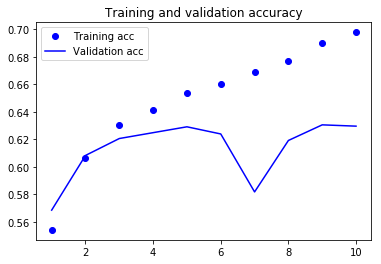

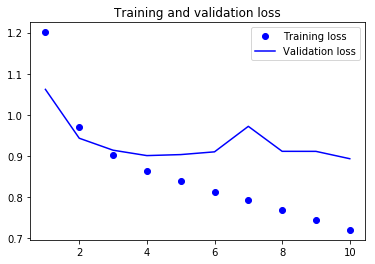

Train on 19023 samples, validate on 2114 samples
Epoch 1/20
19023/19023 [==============================] - 42s 2ms/step - loss: 1.1904 - acc: 0.5553 - val_loss: 1.1052 - val_acc: 0.5856
Epoch 2/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9700 - acc: 0.6001 - val_loss: 1.0207 - val_acc: 0.5814
Epoch 3/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8754 - acc: 0.6415 - val_loss: 0.9298 - val_acc: 0.6367
Epoch 4/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.7939 - acc: 0.6677 - val_loss: 0.9720 - val_acc: 0.6377
Epoch 5/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.7330 - acc: 0.6969 - val_loss: 1.1601 - val_acc: 0.5312
Epoch 6/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.6592 - acc: 0.7318 - val_loss: 1.2098 - val_acc: 0.5407
Epoch 7/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.5870 - acc: 0.7637 - val_loss: 1.1012 - val_acc:

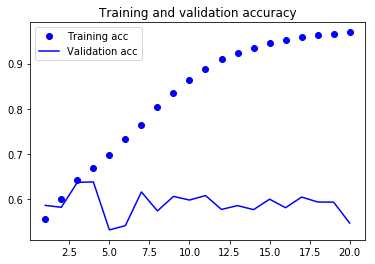

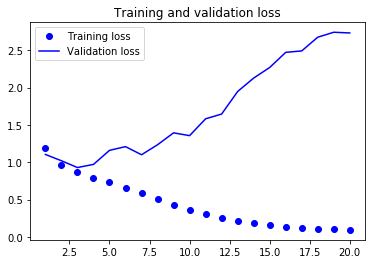

Train on 19023 samples, validate on 2114 samples
Epoch 1/30
19023/19023 [==============================] - 72s 4ms/step - loss: 6.9799 - acc: 0.5582 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 2/30
19023/19023 [==============================] - 52s 3ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 3/30
19023/19023 [==============================] - 41s 2ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 4/30
19023/19023 [==============================] - 42s 2ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 5/30
19023/19023 [==============================] - 41s 2ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 6/30
19023/19023 [==============================] - 41s 2ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc: 0.5643
Epoch 7/30
19023/19023 [==============================] - 41s 2ms/step - loss: 7.0749 - acc: 0.5611 - val_loss: 7.0221 - val_acc:

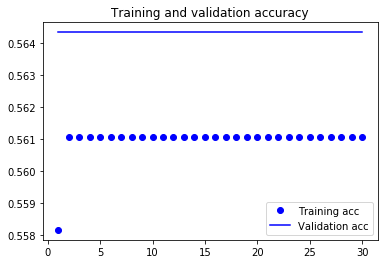

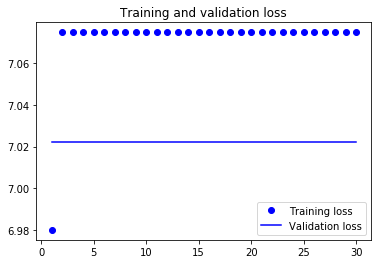

In [14]:
models.clear()
for ep, lr in zip(epcs, lrs):
    create_model(epocas=ep, lr=lr)

In [15]:
loss, acc = models[1].evaluate(X_test, y_test)

2349/2349 [==============================] - 16s 7ms/step


In [16]:
print("Loss: ", loss)
print("Acc: ", acc)

Loss:  2.862979485157349
Acc:  0.5334184760106477


# 1 - D

Train on 19023 samples, validate on 2114 samples
Epoch 1/20
19023/19023 [==============================] - 43s 2ms/step - loss: 1.1958 - acc: 0.5585 - val_loss: 1.0091 - val_acc: 0.5695
Epoch 2/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9701 - acc: 0.5997 - val_loss: 0.9354 - val_acc: 0.6093
Epoch 3/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9005 - acc: 0.6279 - val_loss: 0.9361 - val_acc: 0.6140
Epoch 4/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8602 - acc: 0.6433 - val_loss: 0.8979 - val_acc: 0.6230
Epoch 5/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8274 - acc: 0.6535 - val_loss: 0.8946 - val_acc: 0.6249
Epoch 6/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8059 - acc: 0.6625 - val_loss: 0.8963 - val_acc: 0.6258
Epoch 7/20
19023/19023 [==============================] - 41s 2ms/step - loss: 0.7950 - acc: 0.6683 - val_loss: 0.8934 - val_acc:

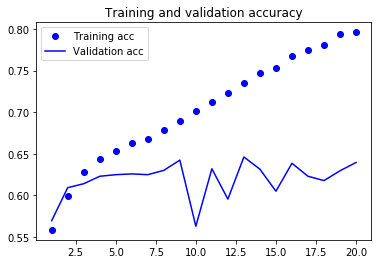

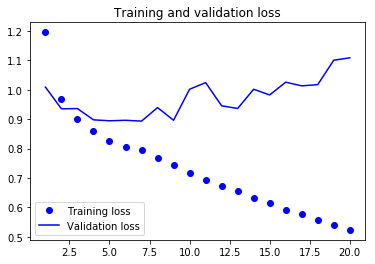

2349/2349 [==============================] - 16s 7ms/step
Loss:  1.218775154581066
Acc:  0.6155810984919659
Train on 19023 samples, validate on 2114 samples
Epoch 1/40
19023/19023 [==============================] - 43s 2ms/step - loss: 1.1873 - acc: 0.5537 - val_loss: 1.0752 - val_acc: 0.5681
Epoch 2/40
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9744 - acc: 0.5991 - val_loss: 0.9350 - val_acc: 0.6131
Epoch 3/40
19023/19023 [==============================] - 42s 2ms/step - loss: 0.9063 - acc: 0.6250 - val_loss: 0.9096 - val_acc: 0.6230
Epoch 4/40
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8704 - acc: 0.6380 - val_loss: 0.9139 - val_acc: 0.6235
Epoch 5/40
19023/19023 [==============================] - 42s 2ms/step - loss: 0.8398 - acc: 0.6485 - val_loss: 0.8923 - val_acc: 0.6239
Epoch 6/40
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8186 - acc: 0.6569 - val_loss: 0.9220 - val_acc: 0.6202
Epoch 7/40
19023/1902

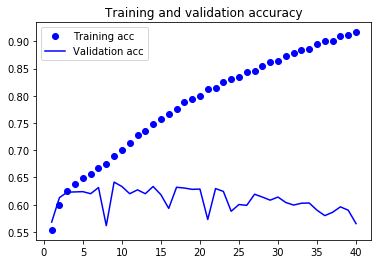

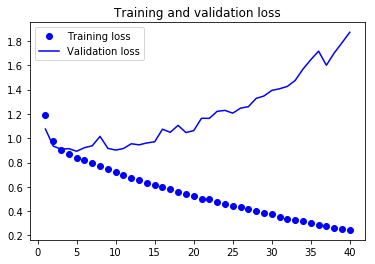

2349/2349 [==============================] - 16s 7ms/step
Loss:  2.0120580797248215
Acc:  0.5466155811110269
Train on 19023 samples, validate on 2114 samples
Epoch 1/60
19023/19023 [==============================] - 43s 2ms/step - loss: 1.1867 - acc: 0.5545 - val_loss: 1.0305 - val_acc: 0.5757
Epoch 2/60
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9734 - acc: 0.6037 - val_loss: 1.0441 - val_acc: 0.5851
Epoch 3/60
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9004 - acc: 0.6265 - val_loss: 1.0087 - val_acc: 0.5870
Epoch 4/60
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8688 - acc: 0.6370 - val_loss: 0.9171 - val_acc: 0.6202
Epoch 5/60
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8410 - acc: 0.6464 - val_loss: 0.8945 - val_acc: 0.6202
Epoch 6/60
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8147 - acc: 0.6552 - val_loss: 0.9224 - val_acc: 0.6225
Epoch 7/60
19023/190

19023/19023 [==============================] - 42s 2ms/step - loss: 0.1288 - acc: 0.9610 - val_loss: 2.9850 - val_acc: 0.5407
Epoch 60/60
19023/19023 [==============================] - 42s 2ms/step - loss: 0.1163 - acc: 0.9633 - val_loss: 3.1494 - val_acc: 0.5653
Épocas: 60  taxa de aprendizagem: 0.001 


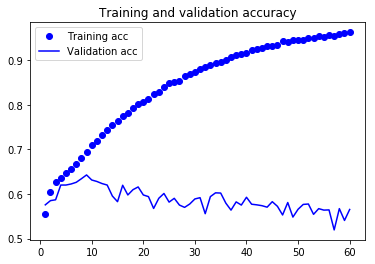

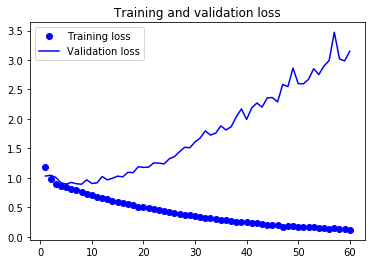

2349/2349 [==============================] - 16s 7ms/step
Loss:  3.3299225936701267
Acc:  0.5606641124263121


In [19]:
quebras = [20, 40, 60]
i = 0
models.clear()
for q in quebras:
    create_model(epocas=q, lr=0.001)
    loss, acc = models[i].evaluate(X_test, y_test)
    print("Loss: ", loss)
    print("Acc: ", acc)
    i = i+1
    

# 1 - E

Train on 19023 samples, validate on 2114 samples
Epoch 1/15
19023/19023 [==============================] - 43s 2ms/step - loss: 1.3036 - acc: 0.4310 - val_loss: 1.1801 - val_acc: 0.5643
Epoch 2/15
19023/19023 [==============================] - 42s 2ms/step - loss: 1.0197 - acc: 0.5850 - val_loss: 0.9446 - val_acc: 0.6031
Epoch 3/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9398 - acc: 0.6139 - val_loss: 0.9493 - val_acc: 0.6017
Epoch 4/15
19023/19023 [==============================] - 42s 2ms/step - loss: 0.8957 - acc: 0.6287 - val_loss: 0.9472 - val_acc: 0.6140
Epoch 5/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8563 - acc: 0.6435 - val_loss: 0.8987 - val_acc: 0.6220
Epoch 6/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8404 - acc: 0.6515 - val_loss: 0.9074 - val_acc: 0.6164
Epoch 7/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8078 - acc: 0.6604 - val_loss: 0.8816 - val_acc:

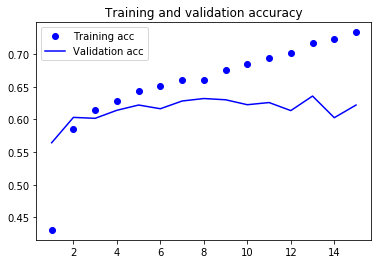

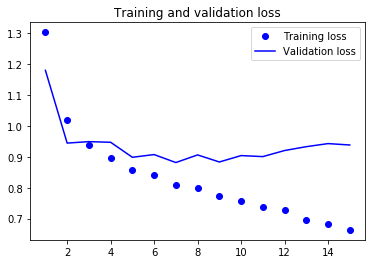

In [22]:
models.clear()
create_model(epocas=15, lr=0.001, units=16)


In [23]:
loss, acc = models[0].evaluate(X_test, y_test)
print("Loss: ", loss)
print("Acc: ", acc)


2349/2349 [==============================] - 16s 7ms/step
Loss:  0.9740808775395523
Acc:  0.5977011494379746


# 1 - F

In [26]:
maxlen=150

Train on 19023 samples, validate on 2114 samples
Epoch 1/15
19023/19023 [==============================] - 43s 2ms/step - loss: 1.1870 - acc: 0.5560 - val_loss: 1.0053 - val_acc: 0.5766
Epoch 2/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.9640 - acc: 0.6061 - val_loss: 0.9814 - val_acc: 0.6017
Epoch 3/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8988 - acc: 0.6302 - val_loss: 0.9336 - val_acc: 0.6112
Epoch 4/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8586 - acc: 0.6426 - val_loss: 0.9019 - val_acc: 0.6149
Epoch 5/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8278 - acc: 0.6506 - val_loss: 0.9694 - val_acc: 0.5984
Epoch 6/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.8096 - acc: 0.6621 - val_loss: 0.9119 - val_acc: 0.6220
Epoch 7/15
19023/19023 [==============================] - 41s 2ms/step - loss: 0.7855 - acc: 0.6721 - val_loss: 0.8900 - val_acc:

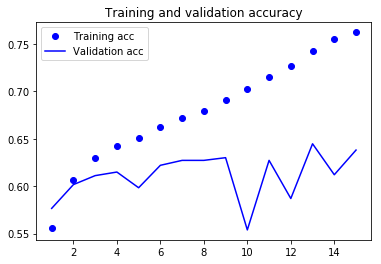

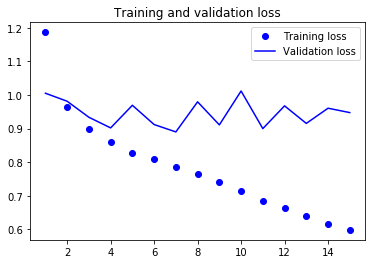

In [29]:
models.clear()

create_model(epocas=15, lr=0.001)

In [30]:
loss, acc = models[0].evaluate(X_test, y_test)
print("Loss: ", loss)
print("Acc: ", acc)

2349/2349 [==============================] - 16s 7ms/step
Loss:  1.0434255294466892
Acc:  0.6164325244911887


# 1 - G

929606it [00:17, 51702.51it/s]


929606 word vectors.
Train on 19023 samples, validate on 2114 samples
Epoch 1/30
19023/19023 [==============================] - 42s 2ms/step - loss: 1.2221 - acc: 0.5591 - val_loss: 1.1847 - val_acc: 0.5639
Epoch 2/30
19023/19023 [==============================] - 40s 2ms/step - loss: 1.1731 - acc: 0.5606 - val_loss: 1.1528 - val_acc: 0.5643
Epoch 3/30
19023/19023 [==============================] - 39s 2ms/step - loss: 1.1561 - acc: 0.5612 - val_loss: 1.1469 - val_acc: 0.5653
Epoch 4/30
19023/19023 [==============================] - 40s 2ms/step - loss: 1.1431 - acc: 0.5631 - val_loss: 1.1727 - val_acc: 0.5662
Epoch 5/30
19023/19023 [==============================] - 40s 2ms/step - loss: 1.1337 - acc: 0.5648 - val_loss: 1.1237 - val_acc: 0.5710
Epoch 6/30
19023/19023 [==============================] - 40s 2ms/step - loss: 1.1163 - acc: 0.5668 - val_loss: 1.0965 - val_acc: 0.5691
Epoch 7/30
19023/19023 [==============================] - 39s 2ms/step - loss: 1.1061 - acc: 0.5706 - val_lo

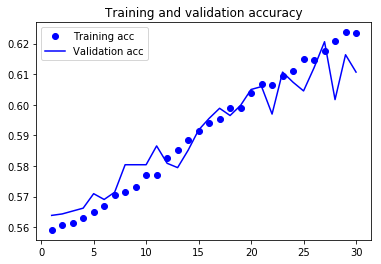

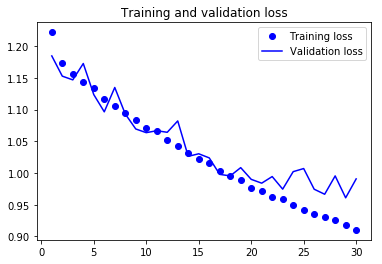

In [31]:
models.clear()
maxlen=300
create_model(epocas=30, lr=0.001, glove=True)

In [32]:
loss, acc = models[0].evaluate(X_test, y_test)
print("Loss: ", loss)
print("Acc: ", acc)

2349/2349 [==============================] - 16s 7ms/step
Loss:  1.0561318581233181
Acc:  0.587058322817379
